In [10]:
import numpy as np
import cv2
import os
import json
import torch
from torch.utils.data import Dataset

In [11]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'slight' if label==1 else 'severe'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, lung_mask, good_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [12]:
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, recall_score, precision_score, auc
import seaborn as sns
import pandas as pd
from scipy import interp
import seaborn as sns
def mkdir(file_dir):
    if os.path.exists(file_dir):
        shutil.rmtree(file_dir)  # 删除再建立
        os.makedirs(file_dir)
    else:
        os.makedirs(file_dir)

def plot_roc_curve_with(fpr, tpr, thresholds, roc_auc, n_bootstrap=1000, save_dir=None):
    plt.figure(figsize=(6, 5))
    plt.title('Abnormal Classification ROC',  fontsize=14)
    plt.plot(fpr, tpr, color='#C9244C', label='Classification AUC = %0.3f' % roc_auc)
    ci_values = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(tpr), len(tpr))
        tpr_bootstrap = tpr[idx]
        fpr_bootstrap = fpr[idx]
        ci_lower = np.maximum(tpr_bootstrap - fpr_bootstrap, 0)
        ci_values.append(ci_lower)
        
    ci_values = np.percentile(ci_values, [2.5, 97.5], axis=0)
    lower_tprs, upper_tprs = ci_values[0], ci_values[1]

    
    plt.plot([0, 1], [0, 1], color='#C0C0C0', linestyle='--', alpha=0.5)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('Sentivity')
    plt.xlabel('1 - Specifity')
    legend =plt.legend(loc='lower right', frameon=True)
    frame = legend.get_frame()
    frame.set_edgecolor('#5D565A')  # 设置图例边框颜色为指定的颜色
    frame.set_linewidth(1)  # 设置图例边框线宽度为1

    best_threshold_index = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_index]
    best_fpr = fpr[best_threshold_index]
    best_tpr = tpr[best_threshold_index]

    # 计算并显示sensitivity、specificity、precision的值和置信区间
    specificity = 1 - fpr
    sensitivity = tpr
    denominator = sensitivity + fpr
    precision = np.divide(sensitivity, denominator, out=np.zeros_like(sensitivity), where=denominator!=0)

    # 添加黑色边框
    for spine in plt.gca().spines.values():
        spine.set_color('black')

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'Resnet18 Cross ROC Abnormal three.png'), dpi=300)
    plt.show()

In [13]:
def calculate_metrics(labels_one_hot_all, pred_scores_all, save_dir=None):
    new_dir = save_dir
    pred_scores_all = torch.cat(pred_scores_all, dim=0).numpy()
    labels_one_hot_all = torch.cat(labels_one_hot_all, dim=0).numpy()
    labels_all = np.argmax(labels_one_hot_all, axis=1)
    
    AUC = roc_auc_score(labels_one_hot_all, pred_scores_all)
    
    pred_scores_all = pred_scores_all[:, 1]
    fpr, tpr, thresholds = roc_curve(labels_all, pred_scores_all)
    if save_dir:
        np.save(os.path.join(new_dir, 'label.npy'), np.array(labels_all))
        np.save(os.path.join(new_dir, 'score.npy'), np.array(pred_scores_all))
    diff = tpr - fpr
    diff[0] = -10
    index = np.argmax(diff)
    thresholds_best = thresholds[index]
    pred_scores_all[pred_scores_all > thresholds_best] = 1
    pred_scores_all[pred_scores_all <= thresholds_best] = 0
    
    ACC = accuracy_score(labels_all, pred_scores_all)
    sensitivity = recall_score(labels_all, pred_scores_all)
    specifity = recall_score(labels_all, pred_scores_all, pos_label=0)
    precision = precision_score(labels_all, pred_scores_all)
    
    global best_AUC
    if AUC > best_AUC:
        best_AUC = AUC
        ROC =  plot_roc_curve_with(fpr, tpr, thresholds, AUC,  save_dir=save_dir) 
    
    return AUC, ACC, sensitivity, specifity, precision

In [14]:

def Confusion_mxtrix(labels_one_hot_all, pred_scores_all, num_classes, save_dir=None):
    new_dir = save_dir
  
    AUC, ACC, sensitivity, specifity, precision = calculate_metrics(labels_one_hot_all, pred_scores_all)
    
    result_df = pd.DataFrame({
        "Metrics": ['AUC', 'ACC', 'Sensitivity', 'Specifity', 'Precision'],
        "Values": [AUC, ACC, sensitivity, specifity, precision]
    })
    
    if save_dir:
        result_df.to_csv(os.path.join(new_dir, 'metrics_table.csv'), index=False)
        
    return AUC, ACC, sensitivity, specifity, precision

In [15]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_abnormal_classification/DDR_data_235/'
abnormal_patient_list = os.listdir(os.path.join(data_root,'slight'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array
normal_patient_list = os.listdir(os.path.join(data_root,'severe'))
normal_labels = np.zeros(len(normal_patient_list)) 

total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 10折交叉验证
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.749  train_accuracy: 0.481


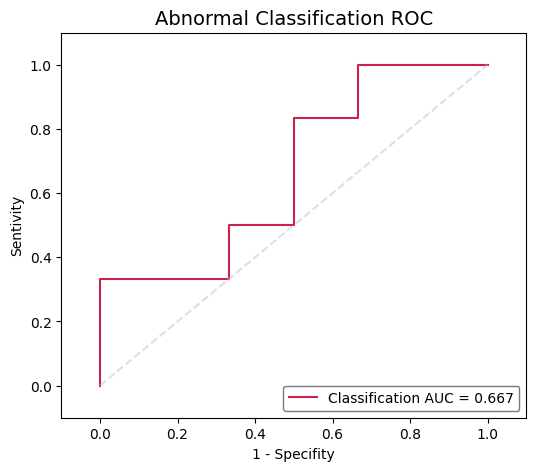

Val_AUC: 0.6666666666666667 Val_ACC: 0.5833333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 2] train_loss: 0.627  train_accuracy: 0.644
Val_AUC: 0.5 Val_ACC: 0.5833333333333334 Val_SEN: 0.8333333333333334 Val_SPE: 0.3333333333333333 Val_PRE: 0.5555555555555556
[epoch 3] train_loss: 0.613  train_accuracy: 0.654
Val_AUC: 0.5555555555555556 Val_ACC: 0.5833333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 4] train_loss: 0.529  train_accuracy: 0.798
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 5] train_loss: 0.496  train_accuracy: 0.817
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 6] train_loss: 0.501  train_accuracy: 0.817
Val_AUC: 0.6388888888888888 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 7] train_loss: 0.474  train

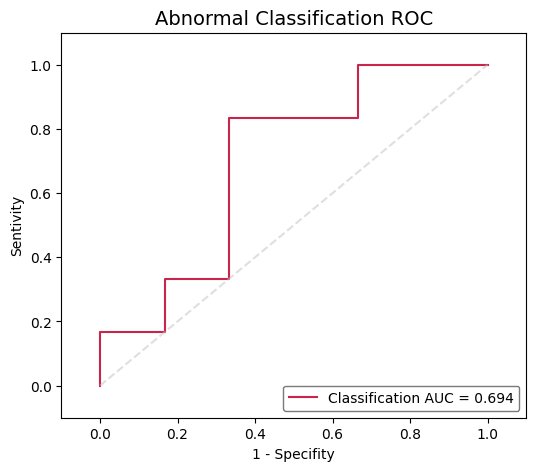

Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 8] train_loss: 0.567  train_accuracy: 0.798
Val_AUC: 0.6666666666666667 Val_ACC: 0.5833333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 9] train_loss: 0.524  train_accuracy: 0.808


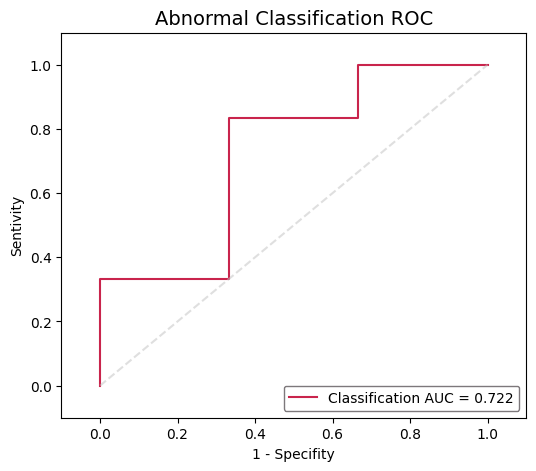

Val_AUC: 0.7222222222222223 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 10] train_loss: 0.469  train_accuracy: 0.837
Val_AUC: 0.7222222222222223 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 11] train_loss: 0.469  train_accuracy: 0.837
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 12] train_loss: 0.469  train_accuracy: 0.846
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 13] train_loss: 0.464  train_accuracy: 0.865
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 14] train_loss: 0.453  train_accuracy: 0.885
Val_AUC: 0.6111111111111112 Val_ACC: 0.5

Val_AUC: 0.6111111111111112 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 54] train_loss: 0.447  train_accuracy: 0.846
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 55] train_loss: 0.389  train_accuracy: 0.933
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 56] train_loss: 0.473  train_accuracy: 0.875
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 57] train_loss: 0.411  train_accuracy: 0.875
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 58] train_loss: 0.438  train_accuracy: 0.913
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 59] t

[epoch 99] train_loss: 0.432  train_accuracy: 0.904
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 100] train_loss: 0.421  train_accuracy: 0.933
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 101] train_loss: 0.386  train_accuracy: 0.942
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 102] train_loss: 0.427  train_accuracy: 0.894
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 103] train_loss: 0.449  train_accuracy: 0.885
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 104] train_loss: 0.409  train

[epoch 142] train_loss: 0.408  train_accuracy: 0.894
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 143] train_loss: 0.388  train_accuracy: 0.933
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 144] train_loss: 0.417  train_accuracy: 0.904
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 145] train_loss: 0.409  train_accuracy: 0.894
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 146] train_loss: 0.384  train_accuracy: 0.952
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 147] train_loss: 0.396  train_accuracy: 0.923
Val_AUC: 0

[epoch 186] train_loss: 0.391  train_accuracy: 0.942
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 187] train_loss: 0.422  train_accuracy: 0.875
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 188] train_loss: 0.405  train_accuracy: 0.913
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 189] train_loss: 0.477  train_accuracy: 0.904
Val_AUC: 0.6666666666666667 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 190] train_loss: 0.402  train_accuracy: 0.904
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 191] train_loss: 0.390  trai

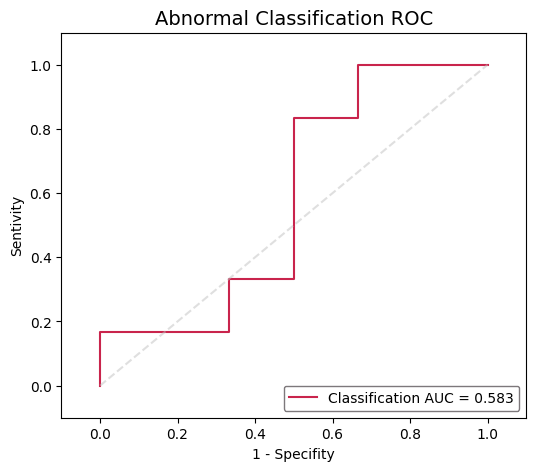

Val_AUC: 0.5833333333333333 Val_ACC: 0.5833333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 2] train_loss: 0.675  train_accuracy: 0.606


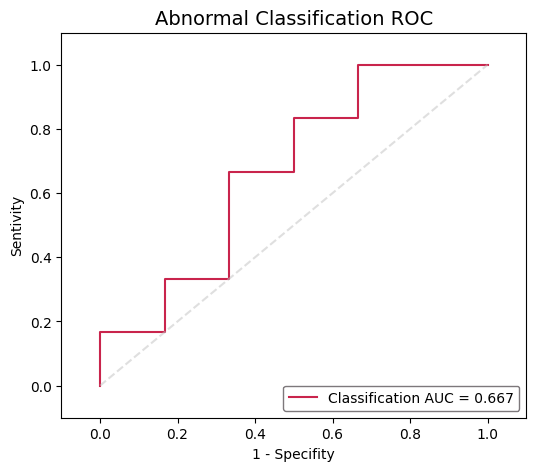

Val_AUC: 0.6666666666666667 Val_ACC: 0.5833333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 3] train_loss: 0.609  train_accuracy: 0.712


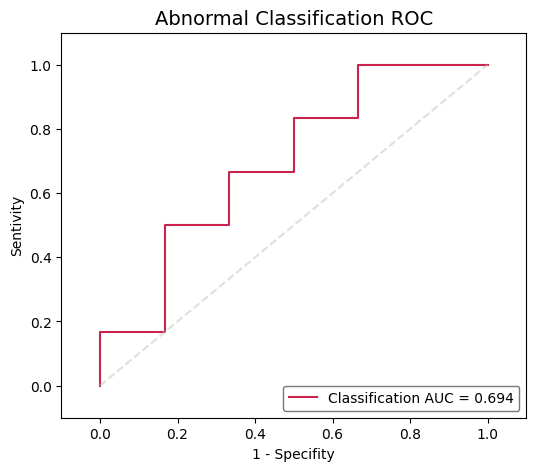

Val_AUC: 0.6944444444444444 Val_ACC: 0.5833333333333334 Val_SEN: 0.3333333333333333 Val_SPE: 0.8333333333333334 Val_PRE: 0.6666666666666666
[epoch 4] train_loss: 0.588  train_accuracy: 0.779
Val_AUC: 0.6944444444444444 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 5] train_loss: 0.593  train_accuracy: 0.692


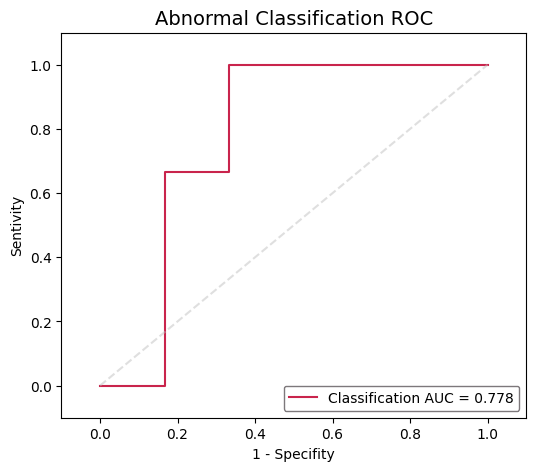

Val_AUC: 0.7777777777777779 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 6] train_loss: 0.522  train_accuracy: 0.808
Val_AUC: 0.7777777777777779 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 7] train_loss: 0.510  train_accuracy: 0.798


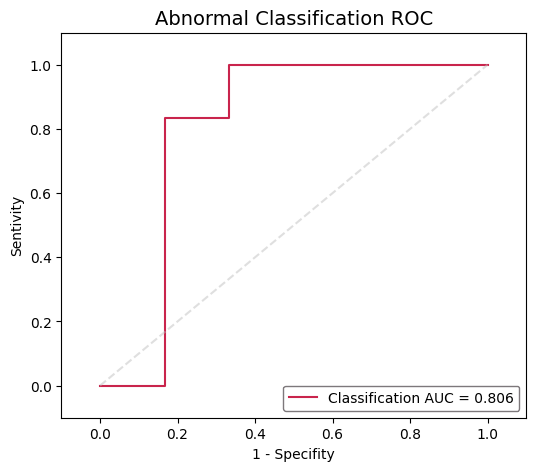

Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 8] train_loss: 0.480  train_accuracy: 0.837
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 9] train_loss: 0.492  train_accuracy: 0.837
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 10] train_loss: 0.539  train_accuracy: 0.779
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 11] train_loss: 0.473  train_accuracy: 0.846
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 12] train_loss: 0.466  train_accuracy: 0.808


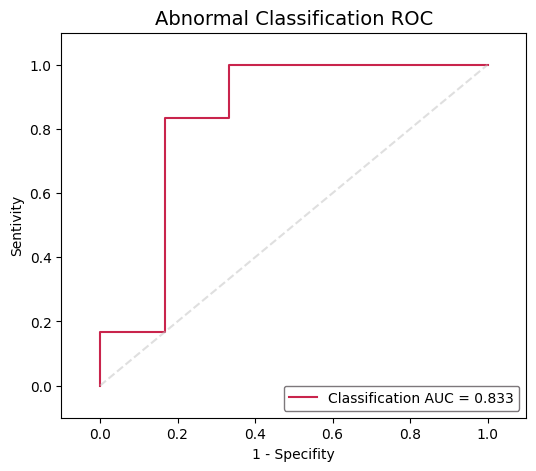

Val_AUC: 0.8333333333333335 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 13] train_loss: 0.488  train_accuracy: 0.856
Val_AUC: 0.8333333333333335 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 14] train_loss: 0.433  train_accuracy: 0.856
Val_AUC: 0.8333333333333335 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 15] train_loss: 0.534  train_accuracy: 0.837
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 16] train_loss: 0.436  train_accuracy: 0.875
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 17] train_loss: 0.438  train_accuracy: 0.837
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 18] train_loss: 0.402  train_accuracy: 0.894
Val_AUC: 0.80555555555

Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 63] train_loss: 0.400  train_accuracy: 0.894
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 64] train_loss: 0.443  train_accuracy: 0.894
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 65] train_loss: 0.427  train_accuracy: 0.885
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 66] train_loss: 0.432  train_accuracy: 0.913
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 67] train_loss: 0.384  train_accuracy: 0.952
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 68] train_loss: 0.423  train_accuracy: 0.875
Val_AUC: 0.80555555555

[epoch 113] train_loss: 0.385  train_accuracy: 0.933
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 114] train_loss: 0.392  train_accuracy: 0.933
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 115] train_loss: 0.419  train_accuracy: 0.913
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 116] train_loss: 0.445  train_accuracy: 0.894
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 117] train_loss: 0.397  train_accuracy: 0.952
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 118] train_loss: 0.388  train_accuracy: 0.962
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 119] trai

[epoch 163] train_loss: 0.431  train_accuracy: 0.856
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 164] train_loss: 0.462  train_accuracy: 0.885
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 165] train_loss: 0.401  train_accuracy: 0.894
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 166] train_loss: 0.427  train_accuracy: 0.875
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 167] train_loss: 0.404  train_accuracy: 0.894
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 168] train_loss: 0.407  train_accuracy: 0.894
Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 169] trai

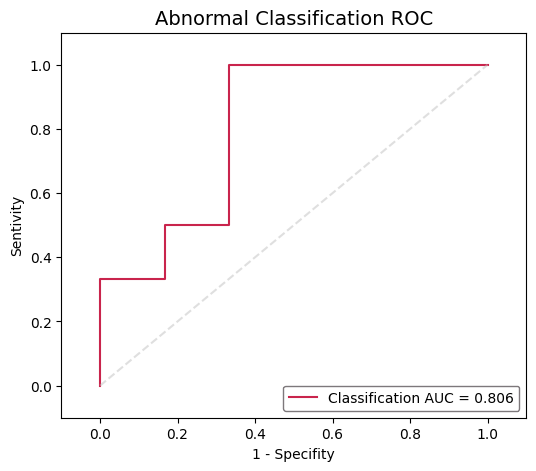

Val_AUC: 0.8055555555555556 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 2] train_loss: 0.725  train_accuracy: 0.510
Val_AUC: 0.7222222222222223 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 3] train_loss: 0.631  train_accuracy: 0.712
Val_AUC: 0.7777777777777779 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 4] train_loss: 0.540  train_accuracy: 0.798


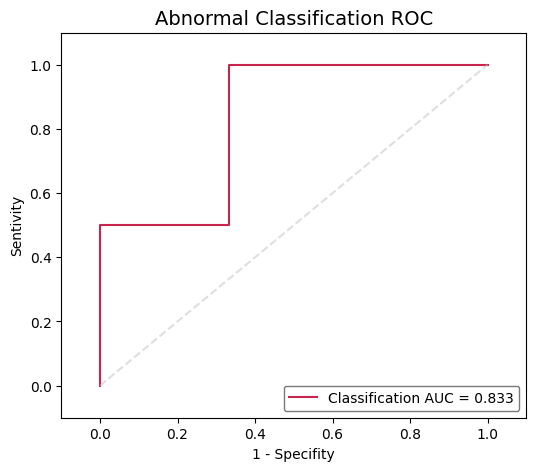

Val_AUC: 0.8333333333333333 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 5] train_loss: 0.547  train_accuracy: 0.740


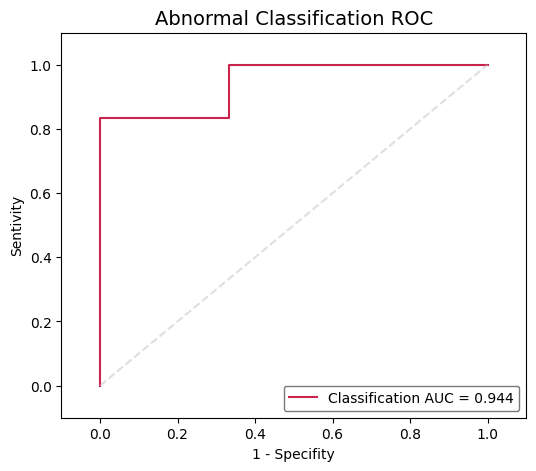

Val_AUC: 0.9444444444444444 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 6] train_loss: 0.500  train_accuracy: 0.827
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 7] train_loss: 0.487  train_accuracy: 0.817
Val_AUC: 0.888888888888889 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 8] train_loss: 0.497  train_accuracy: 0.837
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 9] train_loss: 0.509  train_accuracy: 0.837
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 10] train_loss: 0.454  train_accuracy: 0.856
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 11] train_loss: 0.437  train_accuracy: 0.856
Val_AUC: 0.9444444444444444 

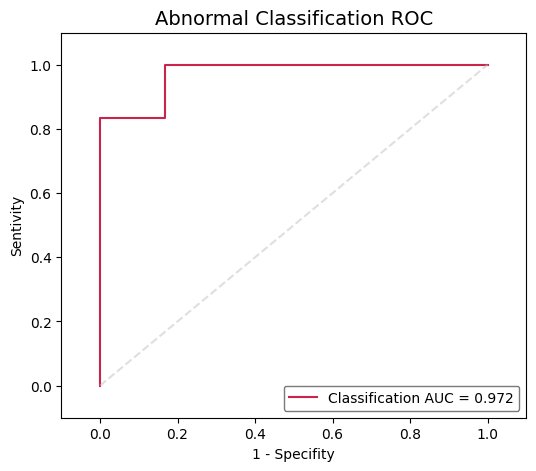

Val_AUC: 0.9722222222222223 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 13] train_loss: 0.453  train_accuracy: 0.856
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 14] train_loss: 0.451  train_accuracy: 0.904
Val_AUC: 0.888888888888889 Val_ACC: 0.75 Val_SEN: 0.8333333333333334 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 15] train_loss: 0.442  train_accuracy: 0.865
Val_AUC: 0.888888888888889 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 16] train_loss: 0.433  train_accuracy: 0.885
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 17] train_loss: 0.484  train_accuracy: 0.856
Val_AUC: 0.9166666666666667 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 18] train_loss: 0.394  train_accuracy: 0.923
Val_AUC: 0

[epoch 63] train_loss: 0.384  train_accuracy: 0.942
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 64] train_loss: 0.399  train_accuracy: 0.913
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 65] train_loss: 0.411  train_accuracy: 0.913
Val_AUC: 0.888888888888889 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 66] train_loss: 0.447  train_accuracy: 0.894
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 67] train_loss: 0.444  train_accuracy: 0.875
Val_AUC: 0.888888888888889 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 68] train_loss: 0.424  train_accuracy: 0.913
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 69] train_loss: 0.405

[epoch 114] train_loss: 0.449  train_accuracy: 0.875
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 115] train_loss: 0.425  train_accuracy: 0.923
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 116] train_loss: 0.411  train_accuracy: 0.894
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 117] train_loss: 0.439  train_accuracy: 0.894
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 118] train_loss: 0.408  train_accuracy: 0.894
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 119] train_loss: 0.443  train_accuracy: 0.894
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 120] train_loss

Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 165] train_loss: 0.381  train_accuracy: 0.952
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 166] train_loss: 0.415  train_accuracy: 0.875
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 167] train_loss: 0.442  train_accuracy: 0.865
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 168] train_loss: 0.419  train_accuracy: 0.865
Val_AUC: 0.888888888888889 Val_ACC: 0.75 Val_SEN: 0.6666666666666666 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 169] train_loss: 0.417  train_accuracy: 0.875
Val_AUC: 0.9166666666666667 Val_ACC: 0.8333333333333334 Val_SEN: 0.6666666666666666 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 170] train_loss: 0.402  train_accuracy: 0.885
Val_AUC: 0.91666666666

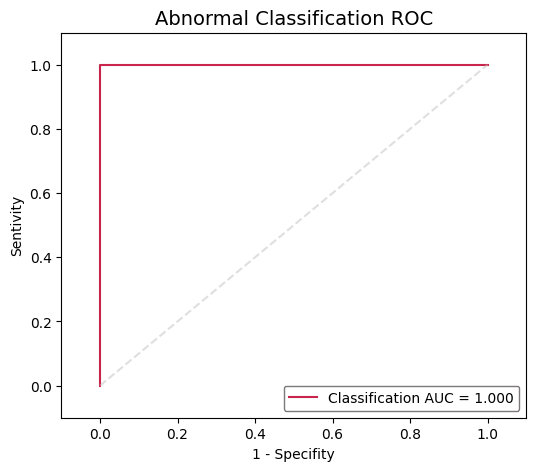

Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 2] train_loss: 0.626  train_accuracy: 0.663
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 3] train_loss: 0.590  train_accuracy: 0.750
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 4] train_loss: 0.586  train_accuracy: 0.721
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 5] train_loss: 0.535  train_accuracy: 0.769
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 6] train_loss: 0.539  train_accuracy: 0.750
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 7] train_loss: 0.517  train_accuracy: 0.827
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 8] train_loss: 0.548  train_accuracy: 0.731
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[ep

[epoch 64] train_loss: 0.437  train_accuracy: 0.856
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 65] train_loss: 0.411  train_accuracy: 0.923
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 66] train_loss: 0.403  train_accuracy: 0.894
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 67] train_loss: 0.383  train_accuracy: 0.952
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 68] train_loss: 0.382  train_accuracy: 0.904
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 69] train_loss: 0.419  train_accuracy: 0.875
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 70] train_loss: 0.430  train_accuracy: 0.894
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 71] train_loss: 0.397  train_accuracy: 0.923
Val_AUC: 1.0 Val_ACC: 0.

[epoch 126] train_loss: 0.394  train_accuracy: 0.904
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 127] train_loss: 0.410  train_accuracy: 0.923
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 128] train_loss: 0.399  train_accuracy: 0.894
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 129] train_loss: 0.421  train_accuracy: 0.894
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 130] train_loss: 0.381  train_accuracy: 0.933
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 131] train_loss: 0.395  train_accuracy: 0.942
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 132] train_loss: 0.389  train_accuracy: 0.942
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 133] train_loss: 0.399  train_accuracy: 0.894
Val_AUC: 1.0 Val

[epoch 188] train_loss: 0.405  train_accuracy: 0.933
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 189] train_loss: 0.428  train_accuracy: 0.904
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 190] train_loss: 0.389  train_accuracy: 0.962
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 191] train_loss: 0.405  train_accuracy: 0.923
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 192] train_loss: 0.429  train_accuracy: 0.885
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 193] train_loss: 0.472  train_accuracy: 0.827
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 194] train_loss: 0.399  train_accuracy: 0.913
Val_AUC: 1.0 Val_ACC: 0.9166666666666666 Val_SEN: 0.8 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 195] train_loss: 0.425  train_accuracy: 0.933
Val_AUC: 1.0 Val

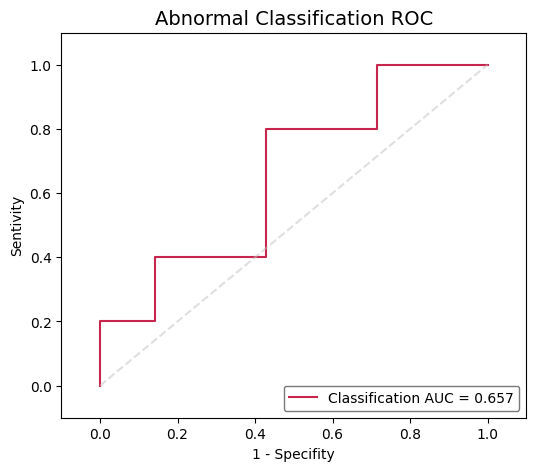

Val_AUC: 0.6571428571428573 Val_ACC: 0.5833333333333334 Val_SEN: 0.6 Val_SPE: 0.5714285714285714 Val_PRE: 0.5
[epoch 2] train_loss: 0.643  train_accuracy: 0.558


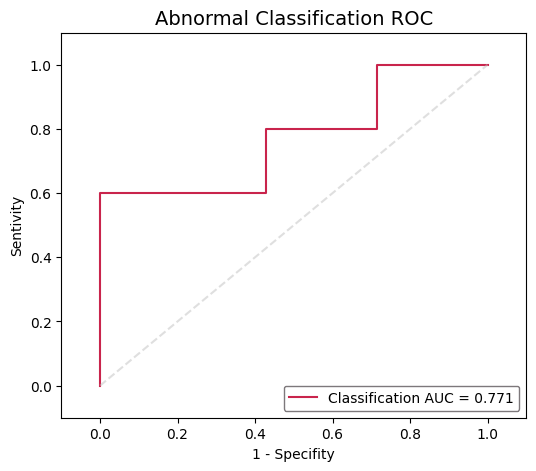

Val_AUC: 0.7714285714285714 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 3] train_loss: 0.595  train_accuracy: 0.702


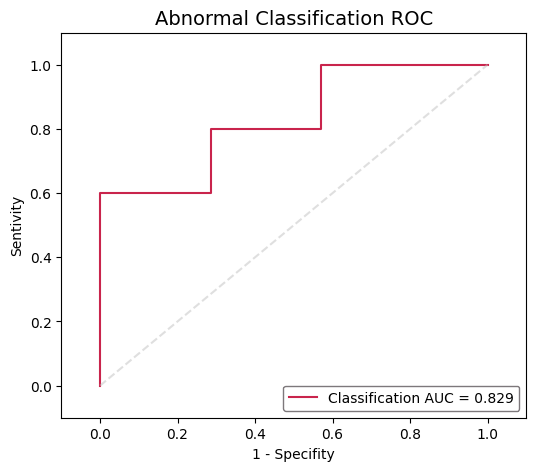

Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 4] train_loss: 0.580  train_accuracy: 0.692
Val_AUC: 0.7714285714285714 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 5] train_loss: 0.623  train_accuracy: 0.635
Val_AUC: 0.7428571428571429 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 6] train_loss: 0.545  train_accuracy: 0.740
Val_AUC: 0.7714285714285714 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 7] train_loss: 0.532  train_accuracy: 0.769


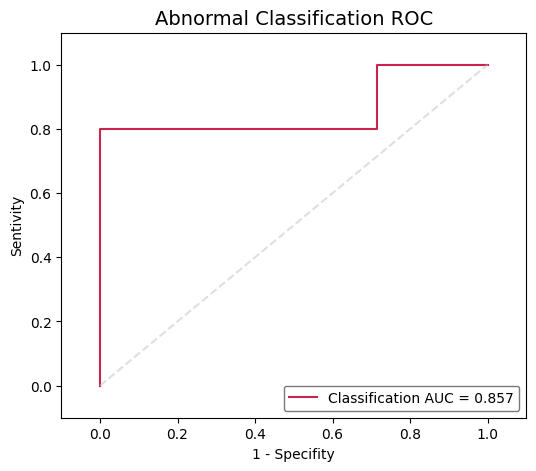

Val_AUC: 0.8571428571428572 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 8] train_loss: 0.491  train_accuracy: 0.846
Val_AUC: 0.8571428571428572 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 9] train_loss: 0.502  train_accuracy: 0.808
Val_AUC: 0.8571428571428572 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 10] train_loss: 0.522  train_accuracy: 0.827
Val_AUC: 0.8571428571428572 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 11] train_loss: 0.480  train_accuracy: 0.875
Val_AUC: 0.8571428571428572 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 12] train_loss: 0.476  train_accuracy: 0.837
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 13] train_loss: 0.492  train_accuracy: 0.817
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 14] train_loss

Val_AUC: 0.8571428571428572 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 69] train_loss: 0.400  train_accuracy: 0.904
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 70] train_loss: 0.430  train_accuracy: 0.865
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 71] train_loss: 0.400  train_accuracy: 0.885
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 72] train_loss: 0.412  train_accuracy: 0.904
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 73] train_loss: 0.402  train_accuracy: 0.913
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 74] train_loss: 0.444  train_accuracy: 0.885
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 75] train_loss: 0.412  train_accuracy: 0.913
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[e

Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 133] train_loss: 0.468  train_accuracy: 0.837
Val_AUC: 0.8571428571428572 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 134] train_loss: 0.390  train_accuracy: 0.933
Val_AUC: 0.8571428571428572 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 135] train_loss: 0.400  train_accuracy: 0.894
Val_AUC: 0.8571428571428572 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 136] train_loss: 0.414  train_accuracy: 0.904
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 137] train_loss: 0.427  train_accuracy: 0.904
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 138] train_loss: 0.398  train_accuracy: 0.913
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 139] train_loss: 0.414  train_accuracy: 0.913
Val_AUC: 0.8571428571428572 Val_ACC: 0.75 Va

[epoch 196] train_loss: 0.386  train_accuracy: 0.913
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 197] train_loss: 0.408  train_accuracy: 0.923
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 198] train_loss: 0.410  train_accuracy: 0.913
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 199] train_loss: 0.421  train_accuracy: 0.894
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 200] train_loss: 0.432  train_accuracy: 0.885
Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
Finished Training
Start trainning: the 5 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.747  train_accuracy: 0.433


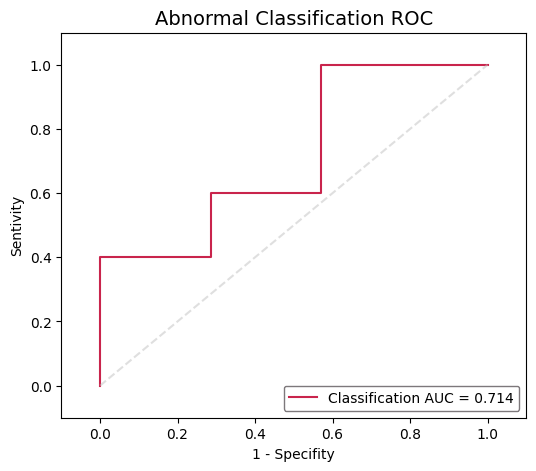

Val_AUC: 0.7142857142857143 Val_ACC: 0.5833333333333334 Val_SEN: 0.8 Val_SPE: 0.42857142857142855 Val_PRE: 0.5
[epoch 2] train_loss: 0.613  train_accuracy: 0.635


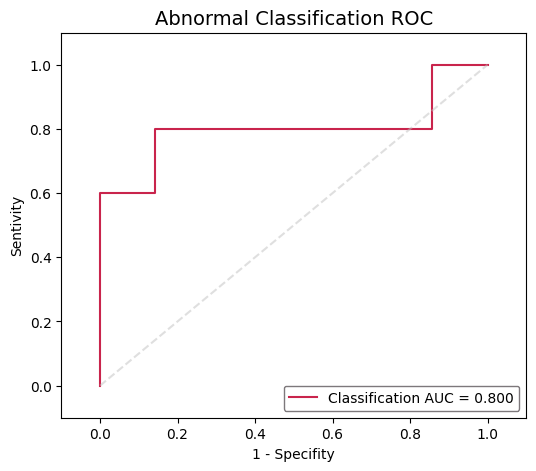

Val_AUC: 0.8 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 3] train_loss: 0.597  train_accuracy: 0.683


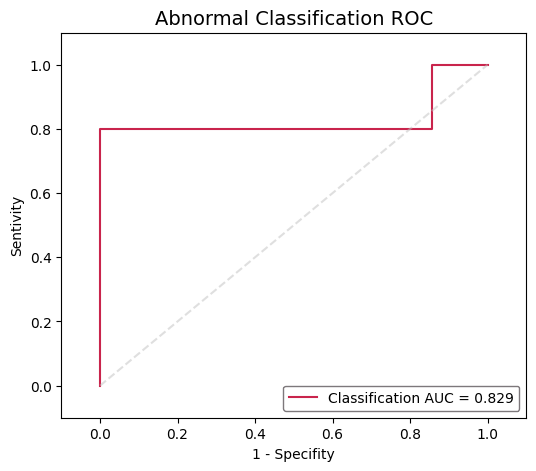

Val_AUC: 0.8285714285714286 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 4] train_loss: 0.523  train_accuracy: 0.817
Val_AUC: 0.8285714285714286 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 5] train_loss: 0.521  train_accuracy: 0.817


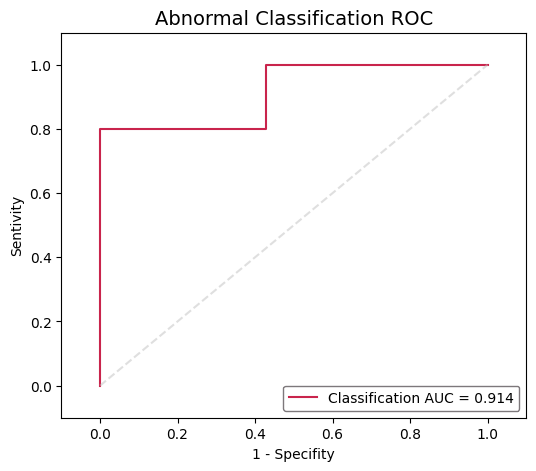

Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 6] train_loss: 0.504  train_accuracy: 0.808
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 7] train_loss: 0.511  train_accuracy: 0.760
Val_AUC: 0.8571428571428572 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 8] train_loss: 0.509  train_accuracy: 0.875
Val_AUC: 0.8285714285714285 Val_ACC: 0.75 Val_SEN: 0.6 Val_SPE: 0.8571428571428571 Val_PRE: 0.75
[epoch 9] train_loss: 0.487  train_accuracy: 0.817
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 10] train_loss: 0.433  train_accuracy: 0.885
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 11] train_loss: 0.481  train_accuracy: 0.750
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 12] train_loss: 0.

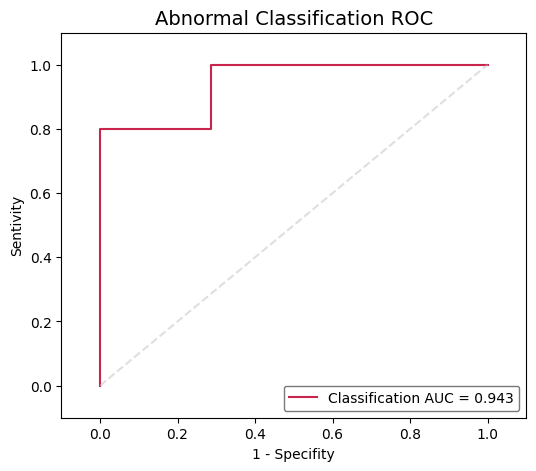

Val_AUC: 0.9428571428571428 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 14] train_loss: 0.538  train_accuracy: 0.760
Val_AUC: 0.9428571428571428 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 15] train_loss: 0.514  train_accuracy: 0.827
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 16] train_loss: 0.454  train_accuracy: 0.865
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 17] train_loss: 0.495  train_accuracy: 0.788
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 18] train_loss: 0.432  train_accuracy: 0.894
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 19] train_loss: 0.437  train_accuracy: 0.885
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 20] train_loss: 

Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 70] train_loss: 0.436  train_accuracy: 0.865
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 71] train_loss: 0.410  train_accuracy: 0.904
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 72] train_loss: 0.419  train_accuracy: 0.865
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 73] train_loss: 0.468  train_accuracy: 0.827
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 74] train_loss: 0.406  train_accuracy: 0.913
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 75] train_loss: 0.435  train_accuracy: 0.885
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 76] train_loss: 

[epoch 125] train_loss: 0.456  train_accuracy: 0.904
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 126] train_loss: 0.410  train_accuracy: 0.894
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 127] train_loss: 0.413  train_accuracy: 0.904
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 128] train_loss: 0.448  train_accuracy: 0.865
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 129] train_loss: 0.401  train_accuracy: 0.913
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 130] train_loss: 0.382  train_accuracy: 0.933
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 131] train_loss: 0.431  train_accuracy: 0.904
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val

Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 181] train_loss: 0.420  train_accuracy: 0.923
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 182] train_loss: 0.443  train_accuracy: 0.856
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 183] train_loss: 0.400  train_accuracy: 0.923
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 184] train_loss: 0.437  train_accuracy: 0.865
Val_AUC: 0.8857142857142857 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 185] train_loss: 0.423  train_accuracy: 0.894
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 186] train_loss: 0.453  train_accuracy: 0.885
Val_AUC: 0.9142857142857144 Val_ACC: 0.8333333333333334 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 187] train

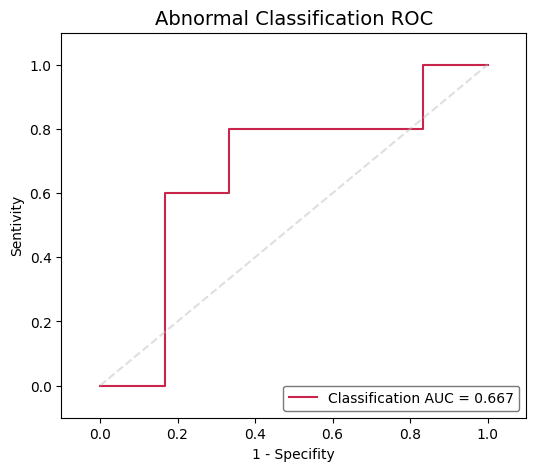

Val_AUC: 0.6666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.6 Val_SPE: 0.6666666666666666 Val_PRE: 0.6
[epoch 2] train_loss: 0.654  train_accuracy: 0.638
Val_AUC: 0.6666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 3] train_loss: 0.577  train_accuracy: 0.733


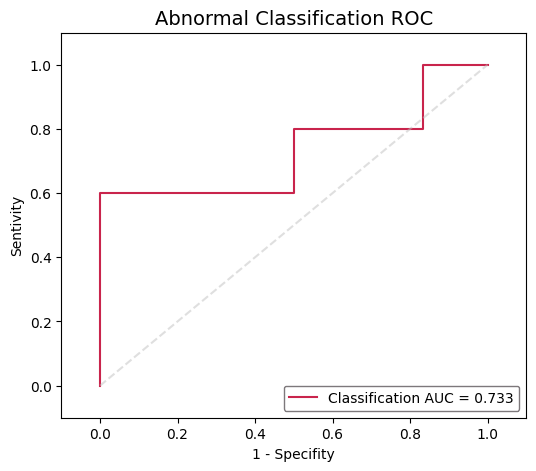

Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 4] train_loss: 0.551  train_accuracy: 0.752


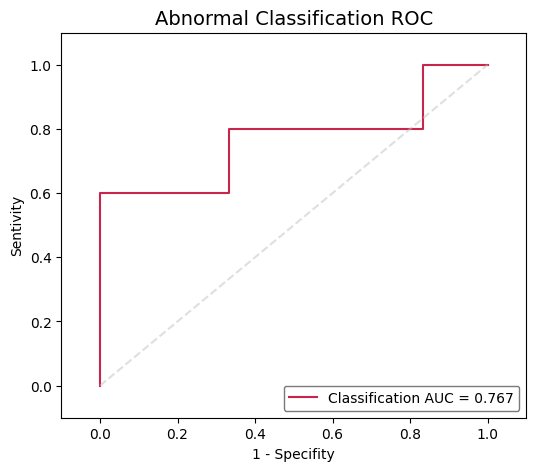

Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 5] train_loss: 0.515  train_accuracy: 0.810
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 6] train_loss: 0.528  train_accuracy: 0.810
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 7] train_loss: 0.461  train_accuracy: 0.857
Val_AUC: 0.6666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.4 Val_SPE: 0.8333333333333334 Val_PRE: 0.6666666666666666
[epoch 8] train_loss: 0.491  train_accuracy: 0.771
Val_AUC: 0.7 Val_ACC: 0.6363636363636364 Val_SEN: 0.4 Val_SPE: 0.8333333333333334 Val_PRE: 0.6666666666666666
[epoch 9] train_loss: 0.488  train_accuracy: 0.838
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 10] train_loss: 0.527  train_accuracy: 0.771
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 

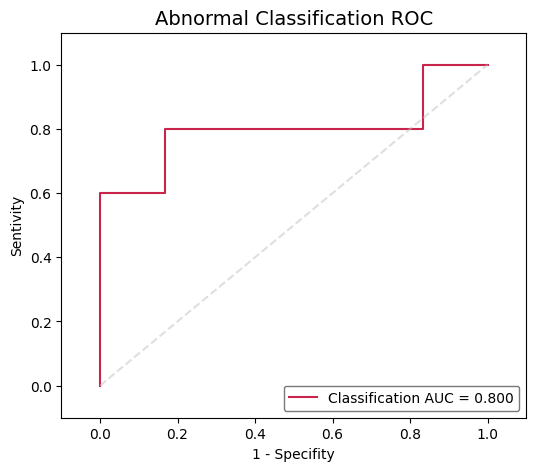

Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.6 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 13] train_loss: 0.422  train_accuracy: 0.867
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 14] train_loss: 0.437  train_accuracy: 0.867
Val_AUC: 0.7 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 15] train_loss: 0.404  train_accuracy: 0.905
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 16] train_loss: 0.437  train_accuracy: 0.886
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 17] train_loss: 0.425  train_accuracy: 0.857
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 18] train_loss: 0.421  train_accuracy: 0.886
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 19] train_loss: 0.442  train_a

[epoch 69] train_loss: 0.387  train_accuracy: 0.933
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 70] train_loss: 0.406  train_accuracy: 0.905
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 71] train_loss: 0.415  train_accuracy: 0.914
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 72] train_loss: 0.429  train_accuracy: 0.905
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 73] train_loss: 0.417  train_accuracy: 0.895
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 74] train_loss: 0.392  train_accuracy: 0.943
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 75] train_loss: 0.392  train_accuracy: 0.905
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0

Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 126] train_loss: 0.423  train_accuracy: 0.914
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 127] train_loss: 0.392  train_accuracy: 0.924
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 128] train_loss: 0.420  train_accuracy: 0.895
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 129] train_loss: 0.405  train_accuracy: 0.933
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 130] train_loss: 0.405  train_accuracy: 0.886
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 131] train_loss: 0.411  train_accuracy: 0.933
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 132] train_loss: 0.406  t

Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 183] train_loss: 0.412  train_accuracy: 0.895
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 184] train_loss: 0.402  train_accuracy: 0.933
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 185] train_loss: 0.401  train_accuracy: 0.924
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 186] train_loss: 0.407  train_accuracy: 0.905
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 187] train_loss: 0.439  train_accuracy: 0.857
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 188] train_loss: 0.400  train_accuracy: 0.943
Val_AUC: 0.7333333333333333 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 189] train

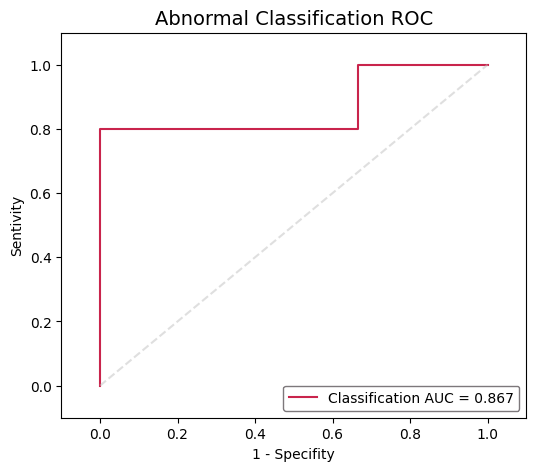

Val_AUC: 0.8666666666666667 Val_ACC: 0.8181818181818182 Val_SEN: 0.6 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 2] train_loss: 0.597  train_accuracy: 0.724


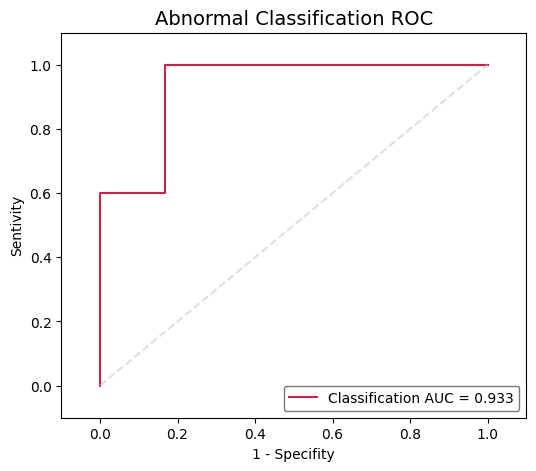

Val_AUC: 0.9333333333333333 Val_ACC: 0.8181818181818182 Val_SEN: 0.8 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 3] train_loss: 0.551  train_accuracy: 0.771
Val_AUC: 0.9000000000000001 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 4] train_loss: 0.535  train_accuracy: 0.762
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.4 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 5] train_loss: 0.551  train_accuracy: 0.781
Val_AUC: 0.8666666666666667 Val_ACC: 0.7272727272727273 Val_SEN: 0.6 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 6] train_loss: 0.506  train_accuracy: 0.838
Val_AUC: 0.8666666666666667 Val_ACC: 0.7272727272727273 Val_SEN: 0.6 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 7] train_loss: 0.485  train_accuracy: 0.800
Val_AUC: 0.9333333333333333 Val_ACC: 0.8181818181818182 Val_SEN: 0.8 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 8] train_loss: 0.486  train_accuracy: 0.867
Val_AUC: 0.9333333333333333 Val_ACC: 0.81818181

Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 53] train_loss: 0.443  train_accuracy: 0.905
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 54] train_loss: 0.447  train_accuracy: 0.876
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 55] train_loss: 0.422  train_accuracy: 0.924
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 56] train_loss: 0.385  train_accuracy: 0.943
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 57] train_loss: 0.393  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 58] train_los

Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 103] train_loss: 0.382  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 104] train_loss: 0.421  train_accuracy: 0.914
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 105] train_loss: 0.410  train_accuracy: 0.867
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 106] train_loss: 0.487  train_accuracy: 0.857
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 107] train_loss: 0.512  train_accuracy: 0.857
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 108] train_loss: 0.388  train_accuracy: 0.952
Val_AUC

[epoch 152] train_loss: 0.394  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 153] train_loss: 0.418  train_accuracy: 0.876
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 154] train_loss: 0.390  train_accuracy: 0.905
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 155] train_loss: 0.382  train_accuracy: 0.905
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 156] train_loss: 0.404  train_accuracy: 0.895
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 157] train_loss: 0.392  train_accuracy: 0.952
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 158] train_loss

[epoch 1] train_loss: 0.705  train_accuracy: 0.552


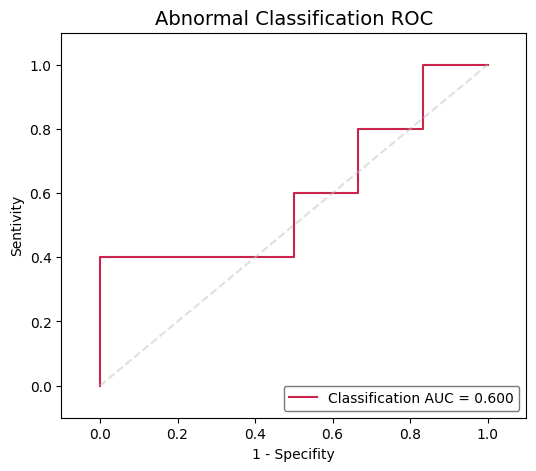

Val_AUC: 0.6 Val_ACC: 0.6363636363636364 Val_SEN: 0.2 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 2] train_loss: 0.637  train_accuracy: 0.667
Val_AUC: 0.4666666666666666 Val_ACC: 0.5454545454545454 Val_SEN: 0.4 Val_SPE: 0.6666666666666666 Val_PRE: 0.5
[epoch 3] train_loss: 0.565  train_accuracy: 0.762
Val_AUC: 0.4666666666666666 Val_ACC: 0.5454545454545454 Val_SEN: 0.4 Val_SPE: 0.6666666666666666 Val_PRE: 0.5
[epoch 4] train_loss: 0.572  train_accuracy: 0.724
Val_AUC: 0.4666666666666666 Val_ACC: 0.5454545454545454 Val_SEN: 0.4 Val_SPE: 0.6666666666666666 Val_PRE: 0.5
[epoch 5] train_loss: 0.569  train_accuracy: 0.762
Val_AUC: 0.4666666666666666 Val_ACC: 0.5454545454545454 Val_SEN: 0.4 Val_SPE: 0.6666666666666666 Val_PRE: 0.5
[epoch 6] train_loss: 0.589  train_accuracy: 0.762
Val_AUC: 0.4666666666666666 Val_ACC: 0.5454545454545454 Val_SEN: 0.4 Val_SPE: 0.6666666666666666 Val_PRE: 0.5
[epoch 7] train_loss: 0.488  train_accuracy: 0.810
Val_AUC: 0.4 Val_ACC: 0.45454545454545453 Val_SEN: 0.8 Val_SPE: 

/home/uii/.conda/envs/loraya/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 10] train_loss: 0.464  train_accuracy: 0.848
Val_AUC: 0.5333333333333334 Val_ACC: 0.5454545454545454 Val_SEN: 0.2 Val_SPE: 0.8333333333333334 Val_PRE: 0.5
[epoch 11] train_loss: 0.446  train_accuracy: 0.876
Val_AUC: 0.5666666666666667 Val_ACC: 0.5454545454545454 Val_SEN: 0.8 Val_SPE: 0.3333333333333333 Val_PRE: 0.5
[epoch 12] train_loss: 0.444  train_accuracy: 0.867


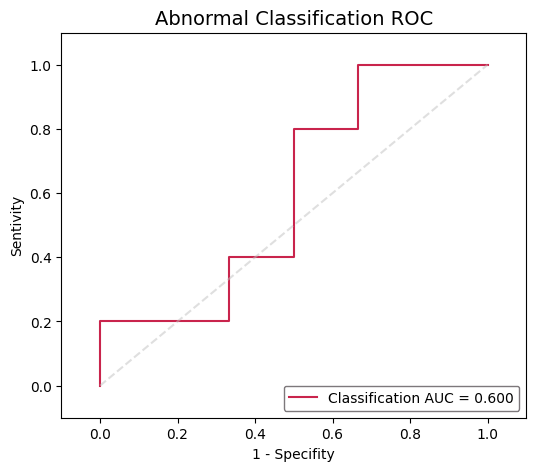

Val_AUC: 0.6000000000000001 Val_ACC: 0.5454545454545454 Val_SEN: 0.8 Val_SPE: 0.3333333333333333 Val_PRE: 0.5
[epoch 13] train_loss: 0.528  train_accuracy: 0.762


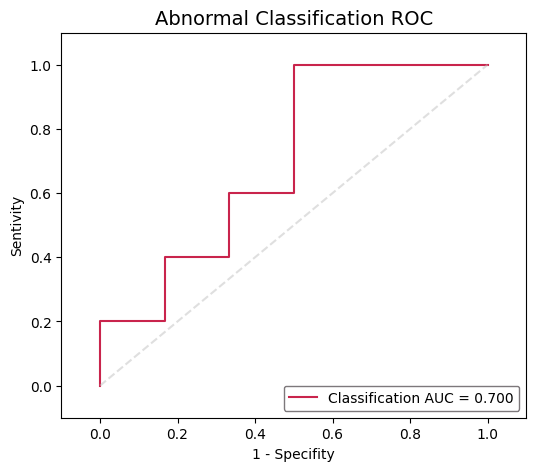

Val_AUC: 0.7 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 14] train_loss: 0.509  train_accuracy: 0.838


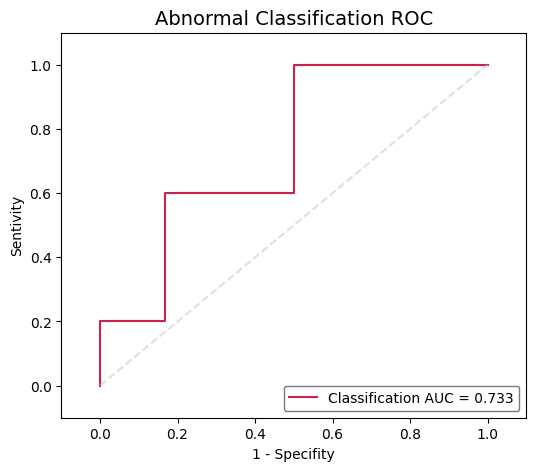

Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 15] train_loss: 0.453  train_accuracy: 0.876
Val_AUC: 0.7 Val_ACC: 0.6363636363636364 Val_SEN: 0.4 Val_SPE: 0.8333333333333334 Val_PRE: 0.6666666666666666
[epoch 16] train_loss: 0.420  train_accuracy: 0.905
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.4 Val_SPE: 0.8333333333333334 Val_PRE: 0.6666666666666666
[epoch 17] train_loss: 0.429  train_accuracy: 0.857
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 18] train_loss: 0.449  train_accuracy: 0.848


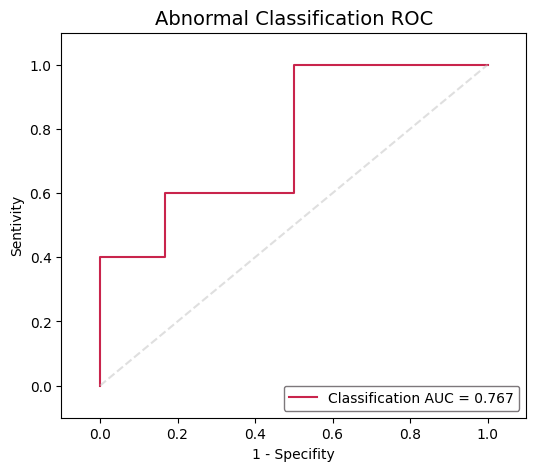

Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 19] train_loss: 0.430  train_accuracy: 0.867
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 20] train_loss: 0.400  train_accuracy: 0.924
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 21] train_loss: 0.415  train_accuracy: 0.933
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 22] train_loss: 0.409  train_accuracy: 0.905
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 23] train_loss: 0.438  train_accuracy: 0.876
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 24] train_loss: 0.474  train_accuracy: 0.838
Val_AUC: 0.7666666666666666 

[epoch 69] train_loss: 0.411  train_accuracy: 0.905
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 70] train_loss: 0.428  train_accuracy: 0.905
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 71] train_loss: 0.431  train_accuracy: 0.895
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 72] train_loss: 0.402  train_accuracy: 0.914
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 73] train_loss: 0.394  train_accuracy: 0.924
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 74] train_loss: 0.466  train_accuracy: 0.867
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 75] train_loss: 0.402

[epoch 120] train_loss: 0.448  train_accuracy: 0.914
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 121] train_loss: 0.459  train_accuracy: 0.876
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 122] train_loss: 0.443  train_accuracy: 0.895
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 123] train_loss: 0.411  train_accuracy: 0.886
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 124] train_loss: 0.410  train_accuracy: 0.895
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 125] train_loss: 0.414  train_accuracy: 0.905
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 126] train_loss

Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 171] train_loss: 0.391  train_accuracy: 0.905
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 172] train_loss: 0.492  train_accuracy: 0.867
Val_AUC: 0.7666666666666666 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 173] train_loss: 0.390  train_accuracy: 0.943
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 174] train_loss: 0.461  train_accuracy: 0.886
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 175] train_loss: 0.437  train_accuracy: 0.895
Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 176] train_loss: 0.406  train_accuracy: 0.933
Val_AUC: 0.73333333333

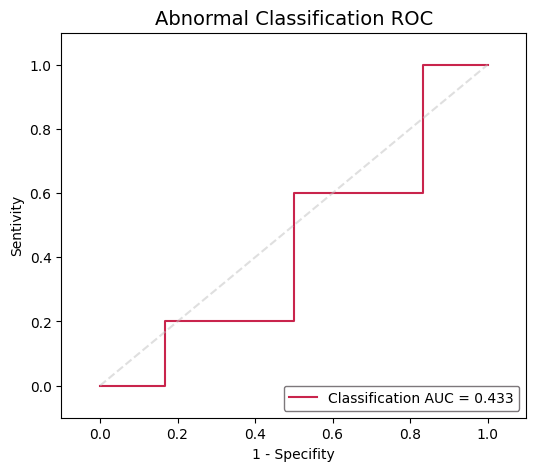

Val_AUC: 0.43333333333333335 Val_ACC: 0.45454545454545453 Val_SEN: 0.8 Val_SPE: 0.16666666666666666 Val_PRE: 0.4444444444444444
[epoch 2] train_loss: 0.659  train_accuracy: 0.676


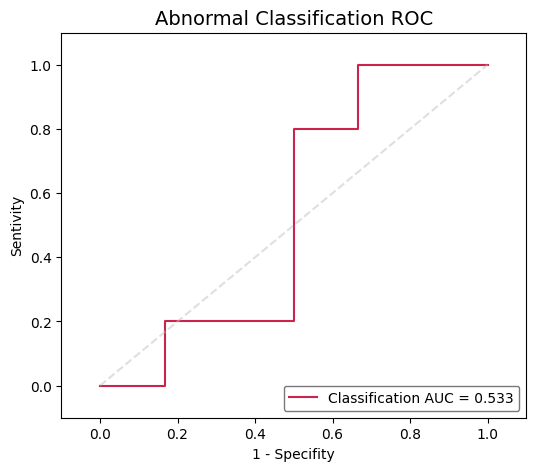

Val_AUC: 0.5333333333333333 Val_ACC: 0.5454545454545454 Val_SEN: 0.8 Val_SPE: 0.3333333333333333 Val_PRE: 0.5
[epoch 3] train_loss: 0.617  train_accuracy: 0.714
Val_AUC: 0.5333333333333333 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 4] train_loss: 0.546  train_accuracy: 0.800


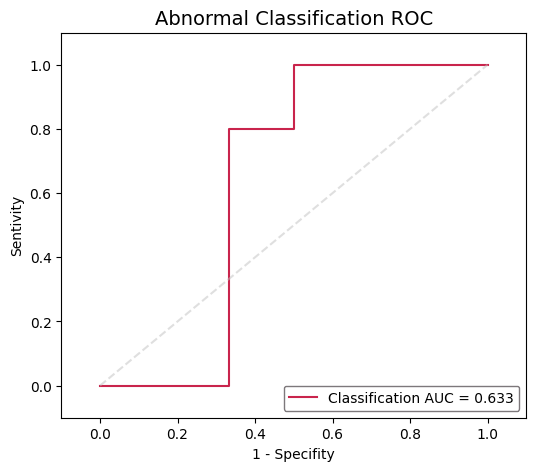

Val_AUC: 0.6333333333333333 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 5] train_loss: 0.529  train_accuracy: 0.790


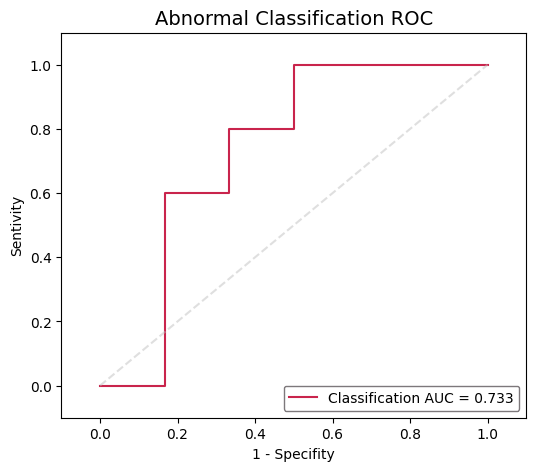

Val_AUC: 0.7333333333333334 Val_ACC: 0.6363636363636364 Val_SEN: 0.8 Val_SPE: 0.5 Val_PRE: 0.5714285714285714
[epoch 6] train_loss: 0.495  train_accuracy: 0.829


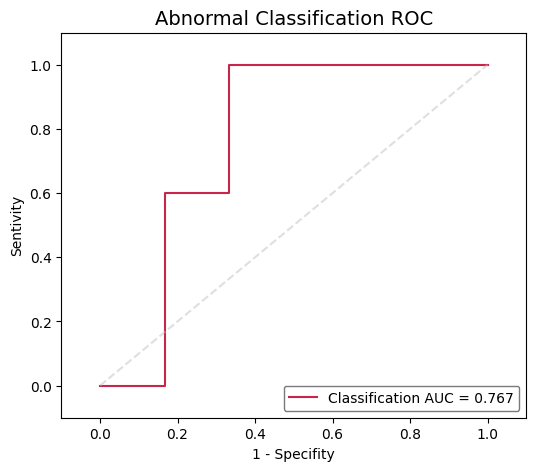

Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 7] train_loss: 0.490  train_accuracy: 0.810
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 8] train_loss: 0.480  train_accuracy: 0.838
Val_AUC: 0.7666666666666666 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 9] train_loss: 0.510  train_accuracy: 0.781
Val_AUC: 0.7333333333333334 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 10] train_loss: 0.495  train_accuracy: 0.819
Val_AUC: 0.7333333333333334 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 11] train_loss: 0.524  train_accuracy: 0.790
Val_AUC: 0.7333333333333334 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666

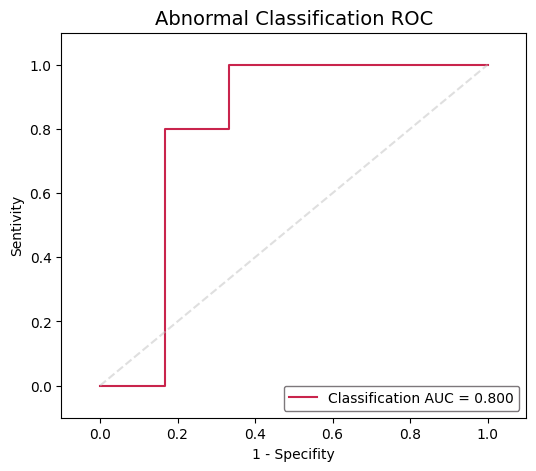

Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 17] train_loss: 0.491  train_accuracy: 0.800
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 18] train_loss: 0.441  train_accuracy: 0.857
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 19] train_loss: 0.405  train_accuracy: 0.886
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 20] train_loss: 0.427  train_accuracy: 0.914
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 21] train_loss: 0.486  train_accuracy: 0.800
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 22] train_loss: 0.415  train_accuracy: 0.876
Val_AUC: 0.8 Val_ACC: 0.7272

[epoch 67] train_loss: 0.379  train_accuracy: 0.943
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 68] train_loss: 0.447  train_accuracy: 0.876
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 69] train_loss: 0.416  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 70] train_loss: 0.430  train_accuracy: 0.895
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 71] train_loss: 0.413  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 72] train_loss: 0.386  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 73] train_loss: 0.446

[epoch 118] train_loss: 0.392  train_accuracy: 0.914
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 119] train_loss: 0.431  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 120] train_loss: 0.419  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 121] train_loss: 0.414  train_accuracy: 0.905
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 122] train_loss: 0.440  train_accuracy: 0.876
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 123] train_loss: 0.430  train_accuracy: 0.876
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 124] train_loss

Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 169] train_loss: 0.403  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 170] train_loss: 0.400  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 171] train_loss: 0.417  train_accuracy: 0.914
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 172] train_loss: 0.390  train_accuracy: 0.924
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 173] train_loss: 0.435  train_accuracy: 0.905
Val_AUC: 0.8 Val_ACC: 0.7272727272727273 Val_SEN: 0.8 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 174] train_loss: 0.403  train_accuracy: 0.933
Val_AUC: 0.8 Val_ACC: 

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200

fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    #输入
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset =DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    best_AUC = 0.0
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_sen,CM_spe,CM_pre = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
        print('Val_AUC: {} Val_ACC: {} Val_SEN: {} Val_SPE: {} Val_PRE: {}'.format(CM_auc,CM_acc,CM_sen,CM_spe,CM_pre))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_,_,_ = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} Sen: {CM_sen} Spe: {CM_spe} Pre: {CM_pre}\n')
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

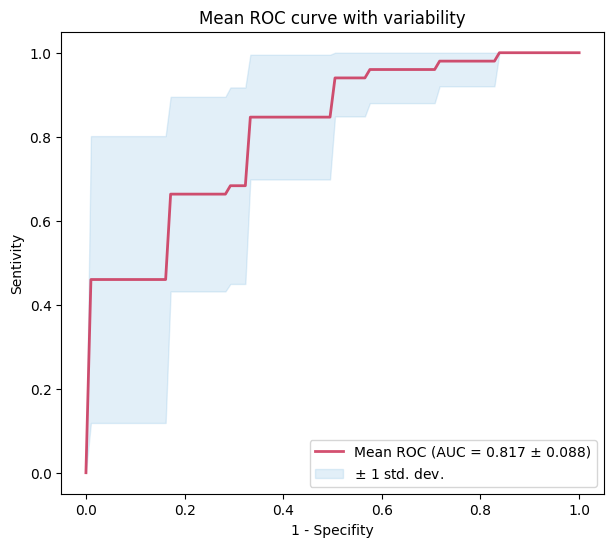

ROC curves saved successfully.


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["severe"]
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(7, 6))
tprs = []
aucs = []
for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#6EB1DE",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")

plt.savefig(('/home/uii/loraya/DDR_abnormal_classification/resnet18_three/inter_roc_fold.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

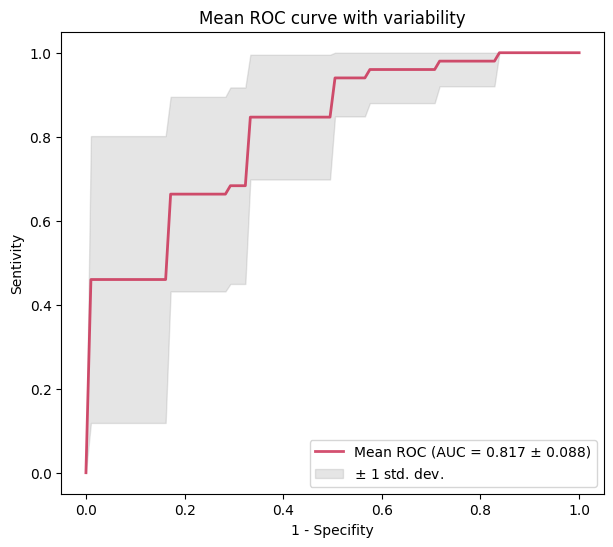

ROC curves saved successfully.


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["severe"]
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(7, 6))
tprs = []
aucs = []
for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")

plt.savefig((f'/home/uii/loraya/DDR_abnormal_classification/resnet18_three/inter_roc_fold1.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
accuracies = []
specificities = []
sensitivities = []
precisions = []

for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    accuracy = (score_three.round() == label_three).mean()
    tn, fp, fn, tp = confusion_matrix(label_three, score_three.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)

    accuracies.append(accuracy)
    specificities.append(specificity)
    sensitivities.append(sensitivity)
    precisions.append(precision)
    aucs.append(three_auc)

mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)
mean_sensitivity = np.mean(sensitivities)
std_sensitivity = np.std(sensitivities)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

results = {
    "Mean AUC": [mean_auc],
    "AUC Std": [std_auc],
    "Mean Accuracy": [mean_accuracy],
    "Accuracy Std": [std_accuracy],
    "Mean Specificity": [mean_specificity],
    "Specificity Std": [std_specificity],
    "Mean Sensitivity": [mean_sensitivity],
    "Sensitivity Std": [std_sensitivity],
    "Mean Precision": [mean_precision],
    "Precision Std": [std_precision]
}

results_df = pd.DataFrame(results, index=["result"])
results_df.to_csv('/home/uii/loraya/DDR_abnormal_classification/resnet18_three/abnormal_results.csv')

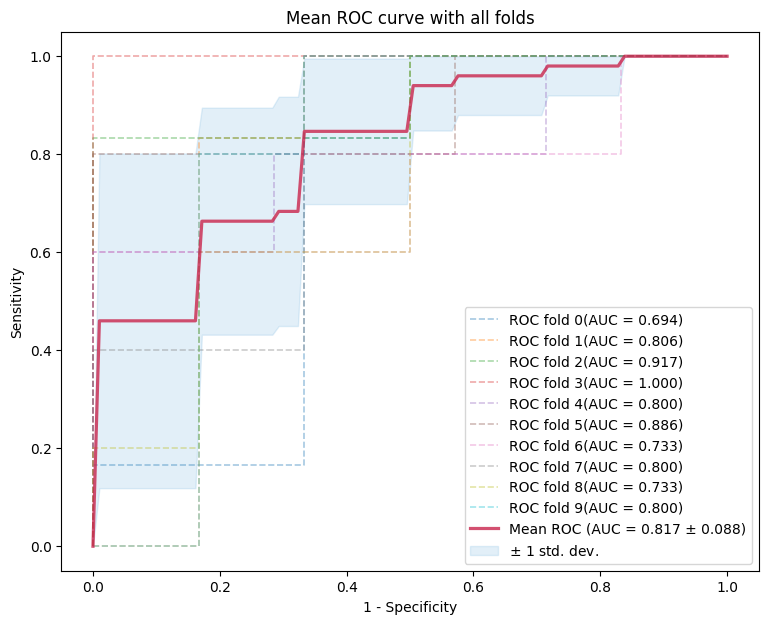

ROC curves saved successfully.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

mean_fpr = np.linspace(0, 1, 100)

# input_name = ['res_18_three','res_18_good_good_good','res_18_hui_good_good','res_18_hui_hui_good'
#               ,'res_18_lung_good_good','res_18_lung_lung_good']
input_name = ['res_18_three']

for input_ in input_name:
    tprs = []
    aucs = []
    
    fig, ax = plt.subplots(figsize=(9, 7))
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_abnormal_classification/Cross_valiation_fold_three/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)

        # 使用细线和虚线，并增加透明度
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(
            ax=ax,
            name=f"ROC fold {fold}(AUC = {three_auc:.3f})",
            linestyle='--',  # 设置虚线
            alpha=0.4,       # 设置透明度
            lw=1.2,            # 设置细线
        )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # 设置主要的平均ROC曲线，增加线宽
    ax.plot(
        mean_fpr,
        mean_tpr,
        color='#C9244C',
        label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        lw=2.3,  # 增加线宽
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="#6EB1DE",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="1 - Specificity",
        ylabel="Sensitivity",
        title=f"Mean ROC curve with all folds",
    )
    ax.legend(loc="lower right")

    plt.savefig((f'/home/uii/loraya/DDR_abnormal_classification/resnet18_three/inter_roc_fold.png'), dpi=500)
    plt.show()

print("ROC curves saved successfully.")